# Homework nr. 3 - features transformation & selection (deadline 13/12/2018)

In short, the main task is to play with transformations and feature selection methods in order to obtain the best results for linear regression model predicting house sale prices.
  
> The instructions are not given in details: It is up to you to come up with ideas on how to fulfill the particular tasks as best you can. ;)

## What are you supposed to do

Your aim is to optimize the _RMSLE_ (see the note below) of the linear regression estimator (=our prediction model) of the observed sale prices.

### Instructions:

  1. Download the dataset from the course pages (hw3_data.csv, hw3_data_description.txt). It corresponds to [this Kaggle competition](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).
  2. Split the dataset into train & test part exactly as we did in the tutorial.
  3. Transform the features properly (don't forget the target variable).
  4. Try to find the best subset of features.
  5. Compare your results with the [Kaggle leaderboard](https://www.kaggle.com/c/house-prices-advanced-regression-techniques/leaderboard). You should be able to reach approximately the top 20% there.
  
Give comments on each step of your solution, with short explanations of your choices.

  
**Note**: _RMSLE_ is a Root-Mean-Squared-Error (RMSE) between the logarithm of the predicted value and the logarithm of the observed sale prices.


## Comments

  * Please follow the instructions from https://courses.fit.cvut.cz/MI-PDD/homeworks/index.html.
  * If the reviewing teacher is not satisfied, he can give you another chance to rework your homework and to obtain more points.

In [1]:
### here comes your code

## Import

In [2]:
import numpy as np
import pandas as pd

from scipy import stats, optimize

from sklearn import model_selection, linear_model, metrics, preprocessing, feature_selection

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import math

%matplotlib inline

## Data

In [3]:
df = pd.read_csv('hw3_data.csv')

Little cleaning

In [4]:
# Convert all object values to categorial format
df[df.select_dtypes(include=['object']).columns] = df.select_dtypes(include=['object']).apply(pd.Series.astype, dtype='category')
# Fill all NaN with 0
df.loc[:,df.select_dtypes(include=['float64']).columns] = df.loc[:,df.select_dtypes(include=['float64']).columns].fillna(0)

In [5]:
df.columns[df.isnull().any()]

Index(['Alley', 'MasVnrType', 'BsmtQual', 'BsmtCond', 'BsmtExposure',
       'BsmtFinType1', 'BsmtFinType2', 'Electrical', 'FireplaceQu',
       'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PoolQC',
       'Fence', 'MiscFeature'],
      dtype='object')

I have some null values, so I need to somehow deal with it

## Basic transformations before split

In [6]:
print("Shape before transformations.")
display(df.shape)

# Convert categorical variables to indicators and create new data
df = pd.get_dummies(df)

#Let us also convert all non-indicator values to float64 - which would be useful later.
df[df.select_dtypes(['float16', 'float64', 'int64']).columns] = df[df.select_dtypes(['float16', 'float64', 'int64']).columns].astype('float64')

# Remove constant features because they are not benefical for our model
df = df[df.columns[df.min() != df.max()]]

# Let us create new features as square roots of Area features - i.e. so they correspond to diameters of circles having the same area
# We also add indicators of zero values (usually missings) there
for column in df.filter(regex='Area|SF', axis=1).columns:  # SF - square foot which means area
    df['Has' + column] = (df[column] > 0).replace({True: 1, False: 0}).astype('uint8')
    df['Sqrt' + column] = np.sqrt(df[column])
    
print("\nShape after transformations.")
display(df.shape)

Shape before transformations.


(1460, 81)


Shape after transformations.


(1460, 320)

In [7]:
df.columns[df.isnull().any()]

Index([], dtype='object')

Now after those transformations there are no empty values, so we can split the data and then select features for the best prediction of SalePrice

## Split train & test (validation) data to be able to study the influence of further steps

In [8]:
dt, dv = model_selection.train_test_split(df, test_size=0.25, random_state=17)
dt = dt.copy()
dv = dv.copy()
print('Train: ', len(dt), '; Validation: ', len(dv))

Train:  1095 ; Validation:  365


#### Prepare models run to be able to study the influence of further steps

In [9]:
def linreg(train, validate, plot = False, train_error = True):
    # Data prepare
    X = train.drop(['SalePrice'], axis = 1, errors = 'ignore')
    y = train.SalePrice
    Xv = validate.drop(['SalePrice'], axis = 1, errors = 'ignore')
    yv = validate.SalePrice   
    
    # Linear Regression train
    clf = linear_model.LinearRegression()
    clf.fit(X, y) 
    
    # Print RMSLE
    print('Linear regression root mean squared validation error:',
          np.sqrt(metrics.mean_squared_error(np.log(clf.predict(Xv)),np.log(yv))))
    if train_error:
        print('Linear regression root mean squared train error:',
            np.sqrt(metrics.mean_squared_error(np.log(clf.predict(X)), np.log(y))))
    
    # Joint Plot
    if plot:
        sns.jointplot(yv, clf.predict(Xv))

In [10]:
def ridgereg(train, validate, plot = False, train_error = True):
    # Prepare functions to automatic alpha determination using cross validation
    def scorer(Y, yp):
        return np.sqrt(metrics.mean_squared_error(Y, yp))
    def ridgemodel(alpha):
        clf = linear_model.Ridge(alpha=alpha)
        return np.mean(model_selection.cross_val_score(clf, X, y, cv=5, scoring=metrics.make_scorer(scorer)))

    # Data prepare
    X = train.drop(['SalePrice'], axis = 1, errors = 'ignore')
    y = train.SalePrice
    Xv = validate.drop(['SalePrice'], axis = 1, errors = 'ignore')
    yv = validate.SalePrice
   
    # Find Ridge alpha automatically
    opt_alpha = optimize.minimize_scalar(ridgemodel, options = {'maxiter': 30}, method = 'bounded', bounds=(0.1, 400))
    
    # Ridge regression model
    clf = linear_model.Ridge(alpha=opt_alpha.x)
    clf.fit(X, y) 
    
    # Print RMSLE
    print('Ridge regression root mean squared validation error:',
          np.sqrt(metrics.mean_squared_error(np.log(clf.predict(Xv)),np.log(yv))))
    if train_error:
        print('Rigde regression root mean squared train error:',
            np.sqrt(metrics.mean_squared_error(np.log(clf.predict(X)),np.log(y))))

## Normalization of features

I decide not to do any normalization, because on tutorial it was proven that it don't help and even make worse results.

## Feature selection

Function to check linear regression without some columns

In [11]:
def check_wo_col(train,validate,columns):
    tmp_t = train.drop(columns,axis = 1, errors = 'ignore')
    tmp_v = validate.drop(columns,axis = 1, errors = 'ignore')
    linreg(tmp_t,tmp_v)
    ridgereg(tmp_t,tmp_v)
    print()

Id don't help in predictions, so I will delete it.

In [12]:
columns_to_remove = ['Id']

I will delete columns with almost no variance in training set, because then they are almost constant and are not good to train

In [13]:
treshold = 0.001
columns_to_remove = list(set(list(dt.columns[dt.var() < treshold]) + columns_to_remove))

In [14]:
check_wo_col(dt,dv,columns_to_remove)

Linear regression root mean squared validation error: 0.17270444723098963
Linear regression root mean squared train error: 0.1064755087662662
Ridge regression root mean squared validation error: 0.14237946283285216
Rigde regression root mean squared train error: 0.12322888892417208



#### Correlation of colums to 'SalePrice' column
If columns are not corelated with SalePrice then they will not help with predictions.
I use linear regression in predictions so I don't care about columns from which SalePrice is not linearly dependent.

In [15]:
corrP = dt.drop(columns_to_remove, axis = 1, errors = 'ignore').corr(method='pearson')
corrS = dt.drop(columns_to_remove, axis = 1, errors = 'ignore').corr(method='spearman')

In [16]:
print(corrP.shape)
print(corrS.shape)

(294, 294)
(294, 294)


In [17]:
treshold = 0.001
col_P = list(corrP.SalePrice[corrP.SalePrice.abs() < treshold].index)
col_S = list(corrS.SalePrice[corrS.SalePrice.abs() < treshold].index)

columns_to_remove_P = list(set(columns_to_remove + col_P))
columns_to_remove_S = list(set(columns_to_remove + col_S))


print("Before",len(columns_to_remove))
print("After Pearson",len(columns_to_remove_P))
print("After Spearman",len(columns_to_remove_S))
print()

print("Pearson correlation")
check_wo_col(dt,dv,columns_to_remove_P)

print("Spearman correlation")
check_wo_col(dt,dv,columns_to_remove_S)

Before 26
After Pearson 30
After Spearman 27

Pearson correlation
Linear regression root mean squared validation error: 0.1725161536296006
Linear regression root mean squared train error: 0.10682037520696315
Ridge regression root mean squared validation error: 0.14208764651474504
Rigde regression root mean squared train error: 0.12296495239283217

Spearman correlation
Linear regression root mean squared validation error: 0.17260585420573896
Linear regression root mean squared train error: 0.10647253356305136
Ridge regression root mean squared validation error: 0.14238348215670554
Rigde regression root mean squared train error: 0.12317093321047443



I decided to delete columns which correlation with SalePrice is less than 0.01.

### Check with p-values

We can delete columns using p-values, when we are not sure what correlation treshold use in calculations of Spearman and Pearson algorithms.

In [18]:
# prepare data
X = dt.drop(columns_to_remove, axis = 1, errors = 'ignore').drop(['SalePrice'], axis = 1, errors = 'ignore')
y = dt.SalePrice

# calculate F values for correlation coefficient (calculated from rho using an increasing function)
# calculate p-values of the correspondong F-test (inversely proportional to rho)
Fscores, pvals = feature_selection.f_regression(X,y)
pvals_result = pd.Series(pvals, index = X.columns)

# I will remove colums with too big probability that there was some coincidence in results
additional_columns = list(pvals_result[pvals_result > 0.8].index)
print(additional_columns)
# extend columns_to_remove
columns_to_remove_pp = list(set(columns_to_remove + additional_columns))

['BsmtFinSF2', 'BsmtHalfBath', 'LandContour_Lvl', 'LotConfig_FR2', 'Condition1_RRAn', 'Condition1_RRNe', 'RoofMatl_Tar&Grv', 'Foundation_Wood', 'Fence_GdPrv', 'MiscFeature_Gar2', 'SaleType_CWD', 'SaleCondition_Alloca']


I decided that probability of 80% is acceptable. We will delete columns, which values depend too much on coincidence.

## T-test for indicator variables

To compare indicator varaibles and detect which of those columns to delete to improve performance of predictions.

BsmtFinType2_GLQ     0.997228
RoofStyle_Mansard    0.987682
GarageCond_Gd        0.964432
Foundation_Wood      0.897923
LotConfig_Corner     0.880203
BldgType_TwnhsE      0.853574
RoofMatl_Tar&Grv     0.824290
Condition1_RRAn      0.789933
Fence_GdPrv          0.787946
SaleType_ConLI       0.778721
ExterCond_Ex         0.776527
LotConfig_FR2        0.744095
MiscFeature_Gar2     0.690090
Functional_Mod       0.687068
Foundation_Stone     0.659672
dtype: float64

KitchenQual_TA       8.315298e-95
ExterQual_TA         5.601284e-93
BsmtQual_TA          4.684438e-82
Foundation_PConc     2.762385e-79
GarageType_Detchd    1.417977e-73
GarageFinish_Unf     5.613053e-71
ExterQual_Gd         1.134962e-70
HeatingQC_Ex         9.844340e-68
HasOpenPorchSF       6.314105e-66
HeatingQC_TA         6.479553e-51
dtype: float64

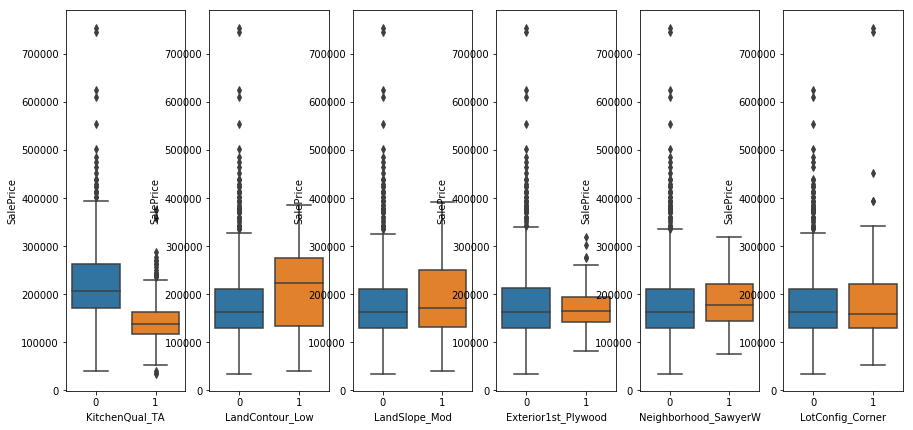

In [19]:
ttest_pvals = df\
    .drop(columns_to_remove, axis = 1, errors = 'ignore')\
    .select_dtypes(include = ['uint8']).columns\
    .to_series()\
    .apply(lambda x: stats.ttest_ind(df.SalePrice[df[x] == 0], df.SalePrice[df[x] == 1], equal_var = False).pvalue)

# show largest and smallest p-values
display(ttest_pvals.nlargest(15))
display(ttest_pvals.nsmallest(10))

fig, axs = plt.subplots(ncols=6, figsize=(15,7))
sns.boxplot(x='KitchenQual_TA', y='SalePrice', data=dt,ax=axs[0])
sns.boxplot(x='LandContour_Low', y='SalePrice', data=dt,ax=axs[1])
sns.boxplot(x='LandSlope_Mod', y='SalePrice', data=dt,ax=axs[2])
sns.boxplot(x='Exterior1st_Plywood', y='SalePrice', data=dt,ax=axs[3])
sns.boxplot(x='Neighborhood_SawyerW', y='SalePrice', data=dt,ax=axs[4])
sns.boxplot(x='LotConfig_Corner', y='SalePrice', data=dt,ax=axs[5])

I can notice that when t-test value is big then target variable is not very diversified.
I see that when the p-value is under 0.5 then we can start to see more diversity, so I will delete all columns with p-value above 0.5

In [20]:
val = 0.5
columns_to_remove_tt1 = list(set(columns_to_remove + list(ttest_pvals[ttest_pvals > val].index)))
columns_to_remove_tt2 = list(set(columns_to_remove_pp + list(ttest_pvals[ttest_pvals > val].index)))
columns_to_remove_tt3 = list(set(columns_to_remove_S + list(ttest_pvals[ttest_pvals > val].index)))
columns_to_remove_tt4 = list(set(columns_to_remove_P + list(ttest_pvals[ttest_pvals > val].index)))

print("With 'normal'")
check_wo_col(dt,dv,columns_to_remove_tt1)
print("With p-values")
check_wo_col(dt,dv,columns_to_remove_pp)
check_wo_col(dt,dv,columns_to_remove_tt2)
print("With Spearman correlation")
check_wo_col(dt,dv,columns_to_remove_S)
check_wo_col(dt,dv,columns_to_remove_tt3)
print("With Pearson correlation")
check_wo_col(dt,dv,columns_to_remove_P)
check_wo_col(dt,dv,columns_to_remove_tt4)

With 'normal'
Linear regression root mean squared validation error: 0.16728110323253317
Linear regression root mean squared train error: 0.10828154381510559
Ridge regression root mean squared validation error: 0.14168364021490187
Rigde regression root mean squared train error: 0.1238755119759083

With p-values
Linear regression root mean squared validation error: 0.1695045612702426
Linear regression root mean squared train error: 0.10685605788638346
Ridge regression root mean squared validation error: 0.14164206298781865
Rigde regression root mean squared train error: 0.12282834592519166

Linear regression root mean squared validation error: 0.1664123333042949
Linear regression root mean squared train error: 0.10829003045040447
Ridge regression root mean squared validation error: 0.14175178456528267
Rigde regression root mean squared train error: 0.12379189024301428

With Spearman correlation
Linear regression root mean squared validation error: 0.17260585420573896
Linear regression ro

I will use those results with wrapper methods and I will compare how those method will change them.

## Wrapper methods

Wrapper methods can help with better selection of features, because it choose the best features compare them as a whole set.
I checked two wrapper methods - RFECV and Lasso.

Function to run RFECV algorithm and show results.

In [21]:
# Prepare the data
def wrapper_rfecv(filtered_dt,filtered_dv):
    X = filtered_dt.drop(['SalePrice'], axis = 1, errors = 'ignore')
    y = filtered_dt.SalePrice

    used_columns = X.columns

    # define the scorer which will be the RMSE
    def scorer(Y, yp):
        return np.sqrt(metrics.mean_squared_error(Y, yp))

    # prepare the model
    clfM = linear_model.LinearRegression()

    # prepare the backward selection algorithm (recursive feature elimination with cross validation)
    selector = feature_selection.RFECV(clfM, step=1, cv=3, scoring=metrics.make_scorer(scorer))
    # run it
    selector = selector.fit(X, y)

    # transform result to dataframe
    result = pd.DataFrame({'Chosen': selector.support_, 'Ranking': selector.ranking_}, index=list(used_columns))
    # columns to leave
    columns_to_leave = result[result.Chosen == True].index
    # show results
    #display(result[result.Chosen == False].head(5))
    print('Chosen', len(columns_to_leave),'from ', result.Chosen.shape[0], 'features.')
    
    #print results
    linreg(filtered_dt[list(columns_to_leave) + ['SalePrice']], filtered_dv[list(columns_to_leave) + ['SalePrice']])
    ridgereg(filtered_dt[list(columns_to_leave) + ['SalePrice']], filtered_dv[list(columns_to_leave) + ['SalePrice']])

Function to run Lasso algorithm and show results. I have chosen max_iter as 50000, becuase with the lower value there was some warning about not enough precision.

In [22]:
def wrapper_lasso(filtered_dt,filtered_dv):
    # Prepare the data
    X = filtered_dt.drop(['SalePrice'], axis = 1, errors = 'ignore')
    y = filtered_dt.SalePrice

    used_columns = X.columns

    # We use the base estimator Lasso since the L1 norm promotes sparsity of features.
    clf = linear_model.Lasso(alpha = 6, max_iter = 50000)

    sfm = feature_selection.SelectFromModel(clf)
    sfm.fit(X, y)

    # transform result to dataframe
    result = pd.DataFrame({'Chosen': sfm.get_support()}, index=list(used_columns))
    # columns to leave
    columns_to_leave = result[result.Chosen == True].index
    # show results
    #display(result[result.Chosen == False].head(5))
    print('Chosen', result.Chosen.sum(),'from ', result.Chosen.shape[0], 'features.')
    
    #print results
    linreg(filtered_dt[list(columns_to_leave) + ['SalePrice']], filtered_dv[list(columns_to_leave) + ['SalePrice']])
    ridgereg(filtered_dt[list(columns_to_leave) + ['SalePrice']], filtered_dv[list(columns_to_leave) + ['SalePrice']])

## Final results

I compare results which I get after using wrapper methods for the following set of columns to remove:
- after T-test values
- after p-values and T-test values
- after Spearman correlation and T-test values
- after Pearson correlation and T-test values

For every set I check ringe regression and linear regression.

In [23]:
columns_to_remove_arr = [columns_to_remove_tt1,columns_to_remove_tt2,columns_to_remove_tt3,columns_to_remove_tt4]
columns_to_remove_names = ["JUST T-TEST","P-VALUES AND T-TEST","SPEARMAN AND T-TEST","PEARSON AND T-TEST"]

for col,name in zip(columns_to_remove_arr,columns_to_remove_names):
    print(name)
    final_columns_to_remove = col
    filtered_dt = dt.drop(final_columns_to_remove, axis = 1, errors = 'ignore')
    filtered_dv = dt.drop(final_columns_to_remove, axis = 1, errors = 'ignore')
    
    print("RFECV")
    wrapper_rfecv(filtered_dt,filtered_dv)
    print("\nLasso")
    wrapper_lasso(filtered_dt,filtered_dv)
    print("\n")

JUST T-TEST
RFECV
Chosen 264 from  273 features.
Linear regression root mean squared validation error: 0.11044622174826468
Linear regression root mean squared train error: 0.11044622174826468
Ridge regression root mean squared validation error: 0.12469625585989726
Rigde regression root mean squared train error: 0.12469625585989726

Lasso
Chosen 234 from  273 features.
Linear regression root mean squared validation error: 0.11598218079218062
Linear regression root mean squared train error: 0.11598218079218062
Ridge regression root mean squared validation error: 0.12392151935818642
Rigde regression root mean squared train error: 0.12392151935818642


P-VALUES AND T-TEST
RFECV
Chosen 209 from  269 features.
Linear regression root mean squared validation error: 0.12182333904708871
Linear regression root mean squared train error: 0.12182333904708871
Ridge regression root mean squared validation error: 0.13199142278854653
Rigde regression root mean squared train error: 0.13199142278854653

L

### Summary and comparison with results from Keggle

We can see that the best result (the lowest validation error) I get when I delete columns using Spearman correlation and T-test and finally running RFECV wrapper algortihm for data without those columns. Also good result I get when I delete columns using only T-test and finally running Lasso wrapper algorithm for data without those columns.

The results around 20% of Kaggle leaderboard is approximately 0.12. The best result which I reach is approximately 0.1096, so I think it is quite fine. I noticed that wrapped methods affect results more than filter methods.

###### I also want to add a coment about why didn't I choose to transform target value. Just because my results are fine without it.

**And a little more comment about it.**
On the tutorial classes it was said that it is good to normalize target value, because it is known that the least squares method
which is behind the linear regression, which is used to predict sale prices, is equivalent to the maximum likelihood method when the target variable has a normal distribution. There was also proposed that we can get target variable normalized by counting logarithm of it. But since I use log in my RMSLE algorithm, then if I will also count logarithm of target variable, I will not get correct results. I tried to count logarithm of target variable and then to count expotential of target variable, but I still got some strange results, so I just leave it without normalization of target variable.
